<a href="https://colab.research.google.com/github/sundram2003/Drone_Detection_using_IR_Dataset/blob/main/IR_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: Setup and Installation
!pip install ultralytics
!pip install opencv-python-headless
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm

import os
import cv2
import numpy as np
from ultralytics import YOLO
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml
import shutil
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 44.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Cell 2: Clone Dataset and Create Directory Structure
!git clone https://github.com/DroneDetectionThesis/Drone-detection-dataset.git
!mkdir -p dataset/images/train dataset/images/val dataset/images/test
!mkdir -p dataset/labels/train dataset/labels/val dataset/labels/test

Cloning into 'Drone-detection-dataset'...
remote: Enumerating objects: 1568, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 1568 (delta 53), reused 107 (delta 50), pack-reused 1457 (from 1)
Receiving objects: 100% (1568/1568), 291.86 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Updating files: 100% (1396/1396), done.


In [4]:
# Cell 3: Prepare Dataset
class DroneDatasetPreparator:
    def __init__(self, base_path="Drone-detection-dataset/Data/Video_IR"):
        self.base_path = base_path
        self.classes = ['AIRPLANE', 'BIRD', 'DRONE', 'HELICOPTER']
        self.frame_interval = 5  # Extract every 5th frame to reduce redundancy

    def extract_frames(self):
        """Extract frames from videos and create YOLO format labels"""
        frame_count = 0

        for class_idx, class_name in enumerate(self.classes):
            print(f"\nProcessing {class_name} videos...")

            # Get all videos for this class
            videos = [f for f in os.listdir(self.base_path)
                     if f.startswith(f"IR_{class_name}") and f.endswith(".mp4")]

            for video_file in tqdm(videos):
                video_path = os.path.join(self.base_path, video_file)
                cap = cv2.VideoCapture(video_path)
                frame_idx = 0

                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break

                    # Process every nth frame
                    if frame_idx % self.frame_interval == 0:
                        # Convert to grayscale and normalize
                        if len(frame.shape) == 3:
                            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                        # Create 3-channel image from grayscale
                        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

                        # Save image
                        img_name = f"frame_{frame_count:06d}.jpg"
                        img_path = f"dataset/images/train/{img_name}"
                        cv2.imwrite(img_path, frame)

                        # Create YOLO format label
                        # Using full frame as bounding box since we don't have specific annotations
                        h, w = frame.shape[:2]
                        label_content = f"{class_idx} 0.5 0.5 1.0 1.0"  # center_x, center_y, width, height

                        with open(f"dataset/labels/train/{img_name.replace('.jpg', '.txt')}", 'w') as f:
                            f.write(label_content)

                        frame_count += 1

                    frame_idx += 1

                cap.release()

        return frame_count

    def split_dataset(self, train_ratio=0.7, val_ratio=0.2):
        """Split dataset into train/val/test sets"""
        all_images = [f for f in os.listdir("dataset/images/train") if f.endswith('.jpg')]

        # First split: separate training set
        train_images, temp_images = train_test_split(
            all_images, train_size=train_ratio, random_state=42
        )

        # Second split: separate validation and test sets
        val_ratio_adjusted = val_ratio / (1 - train_ratio)
        val_images, test_images = train_test_split(
            temp_images, train_size=val_ratio_adjusted, random_state=42
        )

        # Move files to appropriate directories
        for img_set, folder in [(val_images, 'val'), (test_images, 'test')]:
            for img in img_set:
                # Move image
                src_img = f"dataset/images/train/{img}"
                dst_img = f"dataset/images/{folder}/{img}"
                shutil.move(src_img, dst_img)

                # Move corresponding label
                src_label = f"dataset/labels/train/{img.replace('.jpg', '.txt')}"
                dst_label = f"dataset/labels/{folder}/{img.replace('.jpg', '.txt')}"
                shutil.move(src_label, dst_label)

        return len(train_images), len(val_images), len(test_images)

    def create_data_yaml(self):
        """Create data.yaml file for YOLOv8"""
        data_yaml = {
            'path': './dataset',
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'nc': len(self.classes),
            'names': self.classes
        }

        with open('dataset/data.yaml', 'w') as f:
            yaml.dump(data_yaml, f, default_flow_style=False)

In [5]:
# Cell 4: Updated Dataset Preparation
import os
from pathlib import Path
import yaml

class DroneDatasetPreparator:
    def __init__(self, base_path="Drone-detection-dataset/Data/Video_IR"):
        self.base_path = base_path
        self.classes = ['AIRPLANE', 'BIRD', 'DRONE', 'HELICOPTER']
        self.frame_interval = 5  # Extract every 5th frame
        self.dataset_root = os.path.join(os.getcwd(), 'dataset')

    def extract_frames(self):
        """Extract frames from videos and create YOLO format labels"""
        # Create directories if they don't exist
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(self.dataset_root, 'images', split), exist_ok=True)
            os.makedirs(os.path.join(self.dataset_root, 'labels', split), exist_ok=True)

        frame_count = 0

        for class_idx, class_name in enumerate(self.classes):
            print(f"\nProcessing {class_name} videos...")

            videos = [f for f in os.listdir(self.base_path)
                     if f.startswith(f"IR_{class_name}") and f.endswith(".mp4")]

            for video_file in tqdm(videos):
                video_path = os.path.join(self.base_path, video_file)
                cap = cv2.VideoCapture(video_path)
                frame_idx = 0

                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break

                    if frame_idx % self.frame_interval == 0:
                        if len(frame.shape) == 3:
                            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

                        # Save all images initially to train folder
                        img_name = f"frame_{frame_count:06d}.jpg"
                        img_path = os.path.join(self.dataset_root, 'images', 'train', img_name)
                        cv2.imwrite(img_path, frame)

                        # Create label
                        h, w = frame.shape[:2]
                        label_content = f"{class_idx} 0.5 0.5 1.0 1.0"

                        label_path = os.path.join(self.dataset_root, 'labels', 'train',
                                                img_name.replace('.jpg', '.txt'))
                        with open(label_path, 'w') as f:
                            f.write(label_content)

                        frame_count += 1

                    frame_idx += 1

                cap.release()

        return frame_count

    def split_dataset(self, train_ratio=0.7, val_ratio=0.2):
        """Split dataset into train/val/test sets"""
        train_dir = os.path.join(self.dataset_root, 'images', 'train')
        all_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]

        train_images, temp_images = train_test_split(
            all_images, train_size=train_ratio, random_state=42
        )

        val_ratio_adjusted = val_ratio / (1 - train_ratio)
        val_images, test_images = train_test_split(
            temp_images, train_size=val_ratio_adjusted, random_state=42
        )

        # Move files to appropriate directories
        for img_set, folder in [(val_images, 'val'), (test_images, 'test')]:
            for img in img_set:
                # Move image
                src_img = os.path.join(self.dataset_root, 'images', 'train', img)
                dst_img = os.path.join(self.dataset_root, 'images', folder, img)
                shutil.move(src_img, dst_img)

                # Move corresponding label
                src_label = os.path.join(self.dataset_root, 'labels', 'train',
                                       img.replace('.jpg', '.txt'))
                dst_label = os.path.join(self.dataset_root, 'labels', folder,
                                       img.replace('.jpg', '.txt'))
                shutil.move(src_label, dst_label)

        return len(train_images), len(val_images), len(test_images)

    def create_data_yaml(self):
        """Create data.yaml file for YOLOv8"""
        data_yaml = {
            'path': str(self.dataset_root),  # Use absolute path
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'nc': len(self.classes),
            'names': self.classes
        }

        yaml_path = os.path.join(self.dataset_root, 'data.yaml')
        with open(yaml_path, 'w') as f:
            yaml.dump(data_yaml, f, default_flow_style=False)

        return yaml_path


In [6]:
# Cell 5: Prepare Dataset and Train Model
# First prepare the dataset
preparator = DroneDatasetPreparator()
total_frames = preparator.extract_frames()
train_count, val_count, test_count = preparator.split_dataset()
yaml_path = preparator.create_data_yaml()

print(f"\nDataset Statistics:")
print(f"Total frames extracted: {total_frames}")
print(f"Training images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

# Verify dataset structure
def verify_dataset():
    dataset_path = Path('dataset')
    print("\nVerifying dataset structure:")
    for split in ['train', 'val', 'test']:
        img_path = dataset_path / 'images' / split
        label_path = dataset_path / 'labels' / split
        img_count = len(list(img_path.glob('*.jpg')))
        label_count = len(list(label_path.glob('*.txt')))
        print(f"{split}:")
        print(f"  Images: {img_count}")
        print(f"  Labels: {label_count}")

verify_dataset()




Processing AIRPLANE videos...


  0%|          | 0/74 [00:00<?, ?it/s]


Processing BIRD videos...


  0%|          | 0/79 [00:00<?, ?it/s]


Processing DRONE videos...


  0%|          | 0/157 [00:00<?, ?it/s]


Processing HELICOPTER videos...


  0%|          | 0/55 [00:00<?, ?it/s]


Dataset Statistics:
Total frames extracted: 22986
Training images: 16090
Validation images: 4597
Test images: 2299

Verifying dataset structure:
train:
  Images: 16090
  Labels: 16090
val:
  Images: 4597
  Labels: 4597
test:
  Images: 2299
  Labels: 2299


In [7]:
# Now train the model
# Install PyTorch with GPU support and any other dependencies
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install matplotlib h5py pyyaml
# import torch

# Check GPU availability
# if torch.cuda.is_available():
#     print("CUDA is available. GPU is ready to use!")
#     print(f"GPU Name: {torch.cuda.get_device_name(0)}")
# else:
#     print("CUDA is not available. Training will use the CPU.")

# from utils import setup_data_generators, create_model, setup_training, plot_training_history, evaluate_model, save_model_and_weights
import torch


from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # load pretrained model
yaml_path = str(Path('dataset/data.yaml').resolve())

# Train the model with the verified yaml path
results = model.train(
    data=yaml_path,  # Use the absolute path to data.yaml
    epochs=25,
    imgsz=640,
    batch=16,
    name='drone_detection',
    patience=20,
    save=True,
    device='cuda'  # Use GPU if available
)
# Save the trained model
model.save("drone_detection_model.pt")


100%|██████████| 6.25M/6.25M [00:00<00:00, 304MB/s]


Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=25, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=drone_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 99.7MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 134MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/labels/train... 16090 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16090/16090 [00:09<00:00, 1769.89it/s]


train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/labels/val... 4597 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4597/4597 [00:03<00:00, 1310.34it/s]


val: New cache created: /content/dataset/labels/val.cache
Plotting labels to runs/detect/drone_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/drone_detection
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.22G     0.1477     0.9765     0.9268         31        640: 100%|██████████| 1006/1006 [05:27<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:38<00:00,  3.72it/s]


                   all       4597       4597      0.896      0.914      0.966      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.22G      0.109     0.4983     0.8922         34        640: 100%|██████████| 1006/1006 [05:12<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:35<00:00,  4.05it/s]


                   all       4597       4597      0.937      0.947      0.976      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.16G    0.09997     0.4076     0.8888         27        640: 100%|██████████| 1006/1006 [05:17<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  4.00it/s]


                   all       4597       4597      0.905      0.915      0.958      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.16G    0.08702     0.3698     0.8823         32        640: 100%|██████████| 1006/1006 [05:14<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:35<00:00,  4.04it/s]


                   all       4597       4597      0.954      0.968      0.991      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.16G    0.07764     0.3164     0.8818         35        640: 100%|██████████| 1006/1006 [05:11<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.98it/s]


                   all       4597       4597      0.962      0.968      0.985      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.16G    0.07033     0.2896     0.8792         31        640: 100%|██████████| 1006/1006 [05:11<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:35<00:00,  4.05it/s]


                   all       4597       4597      0.972      0.979      0.993      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.16G    0.06545     0.2659     0.8798         27        640: 100%|██████████| 1006/1006 [05:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:35<00:00,  4.09it/s]


                   all       4597       4597      0.985      0.982      0.993      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.16G    0.06294     0.2556     0.8786         33        640: 100%|██████████| 1006/1006 [05:10<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.96it/s]


                   all       4597       4597      0.983      0.984      0.994       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.16G    0.05893     0.2411     0.8782         31        640: 100%|██████████| 1006/1006 [05:11<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:35<00:00,  4.06it/s]


                   all       4597       4597      0.983      0.988      0.994      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.16G    0.05414     0.2268      0.876         33        640: 100%|██████████| 1006/1006 [05:12<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.96it/s]

                   all       4597       4597      0.983      0.992      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.16G    0.05229     0.2161     0.8756         30        640: 100%|██████████| 1006/1006 [05:14<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.98it/s]

                   all       4597       4597      0.989      0.986      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      2.16G     0.0481     0.1983     0.8746         34        640: 100%|██████████| 1006/1006 [05:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.97it/s]

                   all       4597       4597      0.989      0.989      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.16G    0.04647     0.1906     0.8744         34        640: 100%|██████████| 1006/1006 [05:15<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.92it/s]


                   all       4597       4597       0.98      0.992      0.994      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.16G     0.0441     0.1819     0.8755         30        640: 100%|██████████| 1006/1006 [05:09<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.99it/s]


                   all       4597       4597      0.978      0.986      0.994      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.16G     0.0418     0.1724     0.8759         33        640: 100%|██████████| 1006/1006 [05:16<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.96it/s]


                   all       4597       4597      0.993      0.993      0.995      0.995
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.16G    0.04646      0.106     0.8674         10        640: 100%|██████████| 1006/1006 [05:02<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.99it/s]

                   all       4597       4597      0.992      0.992      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.16G    0.03759    0.09017      0.865         10        640: 100%|██████████| 1006/1006 [05:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.95it/s]

                   all       4597       4597      0.992      0.992      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.16G    0.03481    0.07693     0.8634         10        640: 100%|██████████| 1006/1006 [04:59<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:35<00:00,  4.04it/s]


                   all       4597       4597      0.995      0.996      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.16G    0.03221    0.06611     0.8641         10        640: 100%|██████████| 1006/1006 [05:01<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.96it/s]

                   all       4597       4597      0.997      0.995      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.16G    0.02965    0.05695     0.8605         10        640: 100%|██████████| 1006/1006 [04:53<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.99it/s]

                   all       4597       4597      0.997      0.998      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.16G    0.02584    0.04998     0.8631         10        640: 100%|██████████| 1006/1006 [05:02<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:35<00:00,  4.04it/s]


                   all       4597       4597      0.999          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.16G    0.02461     0.0463     0.8639         10        640: 100%|██████████| 1006/1006 [04:58<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:35<00:00,  4.01it/s]


                   all       4597       4597          1          1      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.16G    0.02224    0.04171     0.8615         10        640: 100%|██████████| 1006/1006 [05:01<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.95it/s]

                   all       4597       4597      0.998      0.999      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.16G    0.01993    0.03427     0.8614         10        640: 100%|██████████| 1006/1006 [04:56<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:35<00:00,  4.02it/s]


                   all       4597       4597          1      0.999      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.16G        inf     0.0299     0.8595         10        640: 100%|██████████| 1006/1006 [04:59<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:36<00:00,  3.99it/s]


                   all       4597       4597      0.999          1      0.995      0.995

25 epochs completed in 2.400 hours.
Optimizer stripped from runs/detect/drone_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/drone_detection/weights/best.pt, 6.2MB

Validating runs/detect/drone_detection/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 144/144 [00:39<00:00,  3.67it/s]


                   all       4597       4597      0.999          1      0.995      0.995
              AIRPLANE        915        915      0.996          1      0.995      0.995
                  BIRD       1039       1039          1      0.999      0.995      0.995
                 DRONE       2001       2001      0.999          1      0.995      0.995
            HELICOPTER        642        642          1          1      0.995      0.995
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/drone_detection


In [8]:
# Cell 6: Evaluate Model
# Validate the model
metrics = model.val()

print("\nValidation Metrics:")
print(f"mAP50: {metrics.box.map50:.3f}")
print(f"mAP50-95: {metrics.box.map:.3f}")

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/dataset/labels/val.cache... 4597 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4597/4597 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 288/288 [00:42<00:00,  6.82it/s]


                   all       4597       4597      0.999          1      0.995      0.995
              AIRPLANE        915        915      0.996          1      0.995      0.995
                  BIRD       1039       1039          1      0.999      0.995      0.995
                 DRONE       2001       2001      0.999          1      0.995      0.995
            HELICOPTER        642        642          1          1      0.995      0.995
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/drone_detection2

Validation Metrics:
mAP50: 0.995
mAP50-95: 0.995



image 1/1 /content/dataset/images/test/frame_014071.jpg: 512x640 1 DRONE, 41.7ms
Speed: 2.1ms preprocess, 41.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/dataset/images/test/frame_021290.jpg: 512x640 1 HELICOPTER, 6.7ms
Speed: 2.9ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/dataset/images/test/frame_022168.jpg: 512x640 1 HELICOPTER, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/dataset/images/test/frame_003213.jpg: 512x640 1 AIRPLANE, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/dataset/images/test/frame_015422.jpg: 512x640 1 DRONE, 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


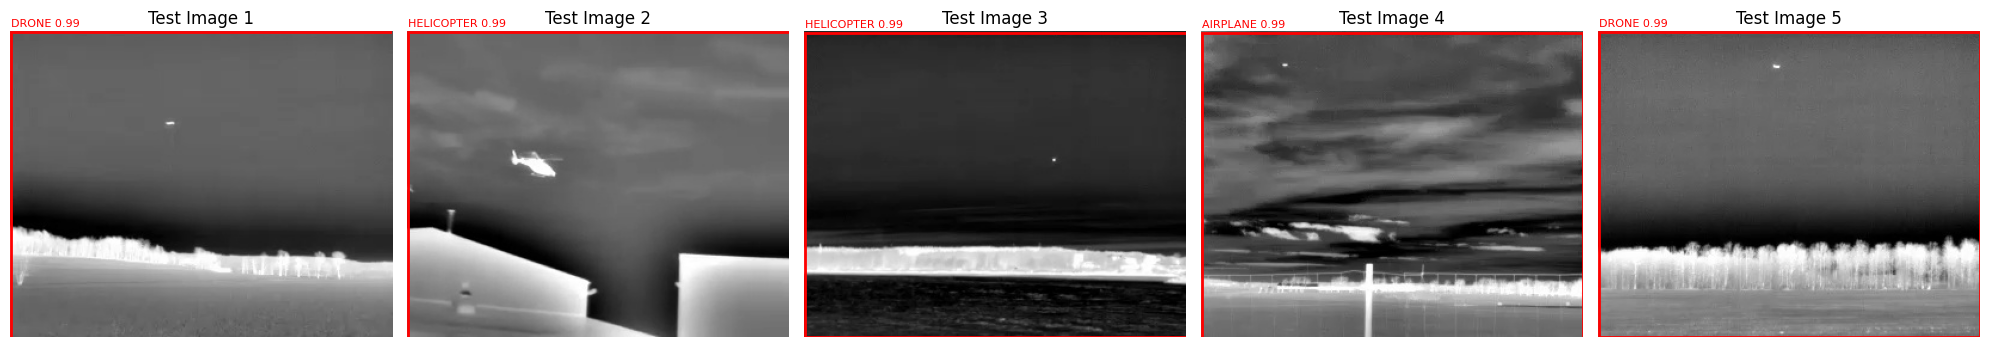

In [14]:
# Cell 7: Visualization and Testing
def visualize_results():
    # Load best model
    best_model = YOLO('/content/drone_detection_model.pt')

    # Get some test images
    test_images = os.listdir('dataset/images/test')[:5]  # Visualize first 5 test images

    plt.figure(figsize=(20, 4))
    for i, img_name in enumerate(test_images, 1):
        img_path = f'dataset/images/test/{img_name}'

        # Run inference
        results = best_model(img_path)

        # Plot results
        plt.subplot(1, 5, i)
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))

        for r in results:
            boxes = r.boxes
            for box in boxes:
                b = box.xyxy[0].cpu().numpy()
                cls = int(box.cls)
                conf = float(box.conf)

                plt.gca().add_patch(plt.Rectangle(
                    (b[0], b[1]), b[2]-b[0], b[3]-b[1],
                    fill=False, color='red', linewidth=2
                ))
                plt.text(
                    b[0], b[1]-5,
                    f'{preparator.classes[cls]} {conf:.2f}',
                    color='red', fontsize=8
                )

        plt.title(f'Test Image {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some results
visualize_results()

In [15]:
# Cell 8: Export Model
# Export the model to ONNX format for deployment
best_model = YOLO('/content/drone_detection_model.pt')
best_model.export(format='onnx')

print("\nModel exported to ONNX format")
print("Export path: runs/detect/drone_detection/weights/best.onnx")

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drone_detection_model.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 213.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 317.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 326.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 258.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 328.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 26.0s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updat

In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available, training will proceed on CPU.")

GPU is available!
Using GPU: Tesla T4
